# Rainfall Analysis and Prediction

---

**Author:** [rodoart](https://github.com/rodoart/)<br>
**Date created:** 2023-01-30<br>
**Last modified:** 2023-01-30<br>
**Description:** Exploring the climate data of Durango, Durango, Mexico.


# 2. Data exploration: Seasonal Analysis

## Path config

Path of Workspace directory and import local libraries.


In [21]:
PROJECT_SLUG = 'rainfall'
NAME = 'data_preparation'
NUMBER = '1.0'

NOTEBOOK_NAME = f'{NUMBER}_{PROJECT_SLUG}-{NAME}.ipynb'


# LOCAL
LOCAL_PATH = '..'

In [22]:
import sys

# It depends on where the library that comes with this package is stored.
sys.path.append(LOCAL_PATH)

In [23]:
from rainfall.utils.paths import make_dir_function

In [24]:
local_dir = make_dir_function(workspace=LOCAL_PATH)

## Libraries

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose

from rainfall.data.make_dataset import StationsDataFrame

from datetime import date

## Load data

In [26]:
STATE = 'Durango'
MUNICIPALITY = 'Durango'

In [27]:

sdf  = StationsDataFrame()
rm_region = sdf.DailyMedians(STATE, MUNICIPALITY)

rm_region

<rainfall.data.make_dataset.daily_medians.<locals>.DailyMedians at 0x1e321295d80>

Interesting data from the days with the most extreme temperatures and the day with the most rain are shown here.

In [28]:
rm_region.df.describe()

,rainfall,evaporation,max_t,min_t
count,27893.000000,27893.000000,27893.000000,27893.000000
mean,1.502228,6.146488,24.467284,7.904213
std,5.894717,2.677750,3.930752,4.078840
min,0.000000,0.100000,5.750000,0.000000
25%,0.000000,4.200000,22.000000,4.400000
50%,0.000000,5.700000,25.000000,8.000000
75%,0.000000,7.750000,27.000000,11.500000
max,97.500000,18.000000,38.000000,20.000000


We created a category, rainy days. According to <https://www.hindawi.com/journals/tswj/2012/894313/>, a rainy day is defined as one in which the rain fall is 2.5 mm.


In [29]:
rm_region.add_is_rainy_col()
rm_region.add_month_number_col()
rm_region.df.head()

,rainfall,evaporation,max_t,min_t,is_rainy,month
date,,,,,,
1941-01-01,0.0,3.3,19.5,3.5,False,1
1941-01-02,0.0,3.8,21.5,2.5,False,1
1941-01-03,0.0,5.8,23.5,5.5,False,1
1941-01-04,0.0,5.7,19.0,7.5,False,1
1941-01-09,0.1,3.6,20.5,3.0,False,1


And remove missing values with interpolation. 

In [30]:
df_region = rm_region.df
df_region = df_region.interpolate(method='time')

### Data plot

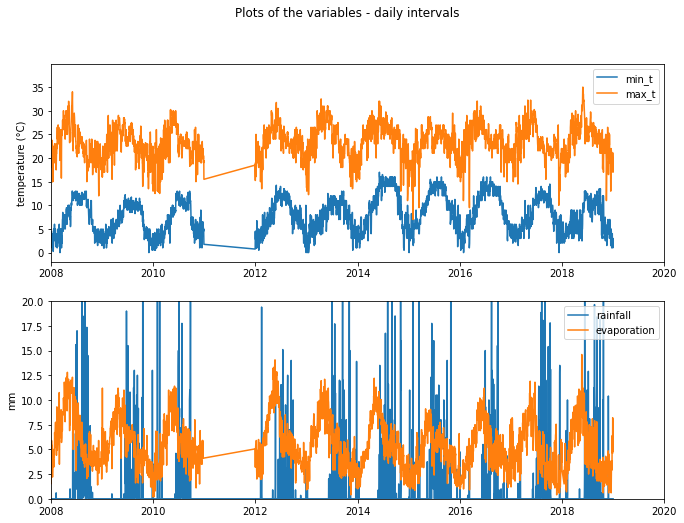

In [31]:
xlim = [datetime(year=2008, month=1, day=1),
              datetime(year=2020, month=1, day=1)]

fig, (ax1, ax2) = plt.subplots(2, 1)

fig.set_figheight(8)
fig.set_figwidth(11)

fig.suptitle('Plots of the variables - daily intervals')

ax1.plot(df_region.index.to_numpy(), df_region['min_t'], label = 'min_t')
ax1.plot(df_region.index.to_numpy(), df_region['max_t'], label = 'max_t')
ax1.set_xlim(xlim)
ax1.set_ylabel('temperature (°C)')
ax1.legend()

ax2.plot(df_region.index.to_numpy(), df_region['rainfall'], label = 'rainfall')
ax2.plot(df_region.index.to_numpy(), df_region['evaporation'], label = 'evaporation')
ax2.set_xlim(xlim)
ax2.set_ylim(0, 20)
ax2.set_ylabel('mm')
ax2.legend()


Note: There is a hole in the data between years 2010 and 2012

## Seasonal Analysis

First, we will make a seasonal analysis to verify how the variables have evolved over time.

### Seasonal yearly component

In [32]:
def seasonal_dataframe_operation(dataframe, column, component, fun, period=365*11):
    series = getattr(
        seasonal_decompose(
            dataframe[column], 
            model='aditive',
            period=period
        ),
        component
    )

    return fun(series)

In [33]:
def plotter(data_function, column_pairs, title=None, ylabels=None, xlabels=None, xlims=None):


    if not xlims:
        xlims = [None for _ in range(2)]

    
    fig, axs = plt.subplots(2, 1)

    fig.set_figheight(8)
    fig.set_figwidth(11)
    
    if title:
        fig.suptitle(title)

    for ax, columns, xlabel, ylabel, xlim in zip(axs, column_pairs, xlabels, ylabels, xlims):
        
        for column in columns:
            ax.plot(data_function(column),label=column)
        
        if ylabel:
            ax.set_ylabel(ylabel)
        
        if xlabel:
            ax.set_xlabel(xlabel)
        
        if xlim:
            ax.set_xlim(xlim)

        ax.legend()
    

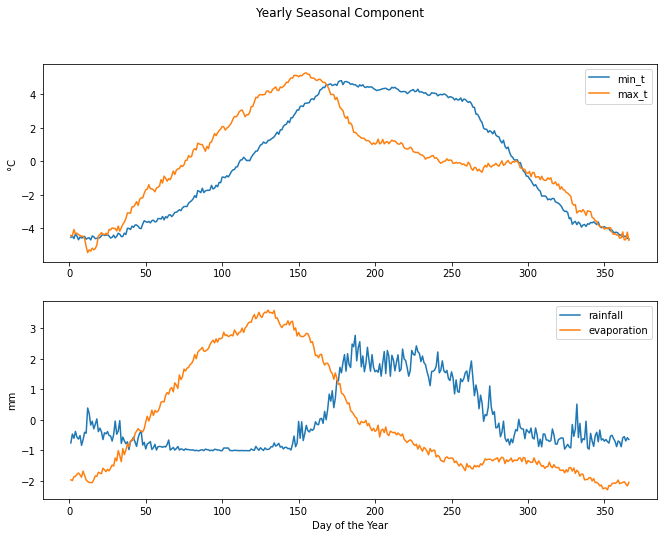

In [34]:
title = 'Yearly Seasonal Component'
column_pairs = [['min_t','max_t'], ['rainfall', 'evaporation']]
ylabels = ['°C', 'mm']
xlabels = ['', 'Day of the Year']
dataframe = df_region[(df_region.index>='1970-01-01')]


def day_of_year_mean(series):
    dataframe = series.to_frame()
    dataframe['day_of_year'] = dataframe.index.dayofyear
    
    
    return dataframe.groupby('day_of_year').mean()


def data_function(column):
    return seasonal_dataframe_operation(dataframe, column, 'seasonal',
                                        day_of_year_mean)

plotter(data_function, column_pairs, title, ylabels, xlabels)

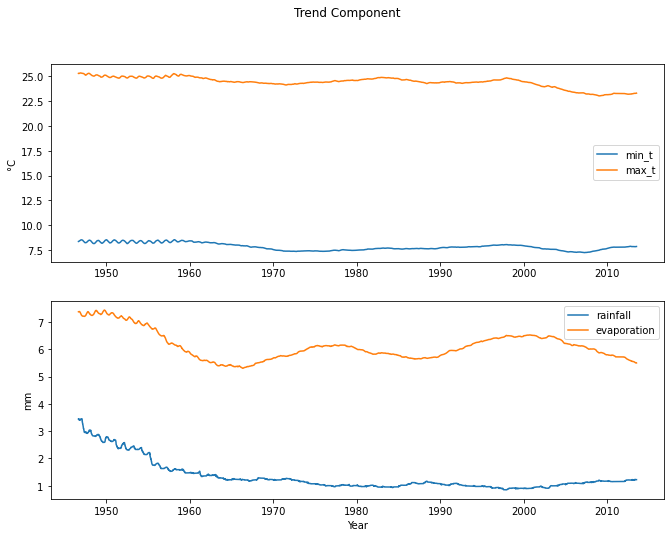

In [35]:

title = 'Trend Component'
column_pairs = [['min_t','max_t'], ['rainfall', 'evaporation']]
ylabels = ['°C', 'mm']
xlabels = ['', 'Year']
dataframe = df_region[(df_region.index>='1940-01-01')]

def data_function(column):
    return seasonal_dataframe_operation(dataframe, column, 'trend',
                                        lambda x: x)

plotter(data_function, column_pairs, title, ylabels, xlabels)

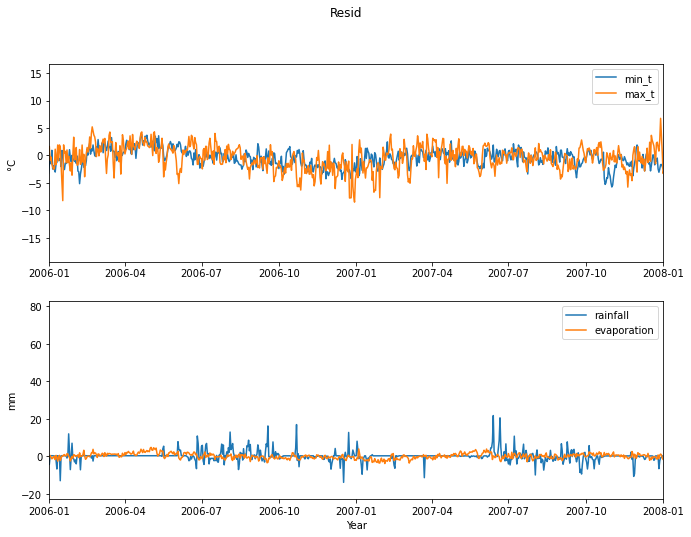

In [36]:

title = 'Resid'
column_pairs = [['min_t','max_t'], ['rainfall', 'evaporation']]
ylabels = ['°C', 'mm']
xlabels = ['', 'Year']
dataframe = df_region[(df_region.index>='1940-01-01')]
xlimits = [(date(2006,1,1), date(2008,1,1)) for _ in range(2)]

def data_function(column):
    return seasonal_dataframe_operation(dataframe, column, 'resid',
                                        lambda x: x)

plotter(data_function, column_pairs, title, ylabels, xlabels, xlimits)

## Variable correlation and distribution.

In [37]:
df_region = rm_region.time_interval_trim((date(1970,1,1), None))

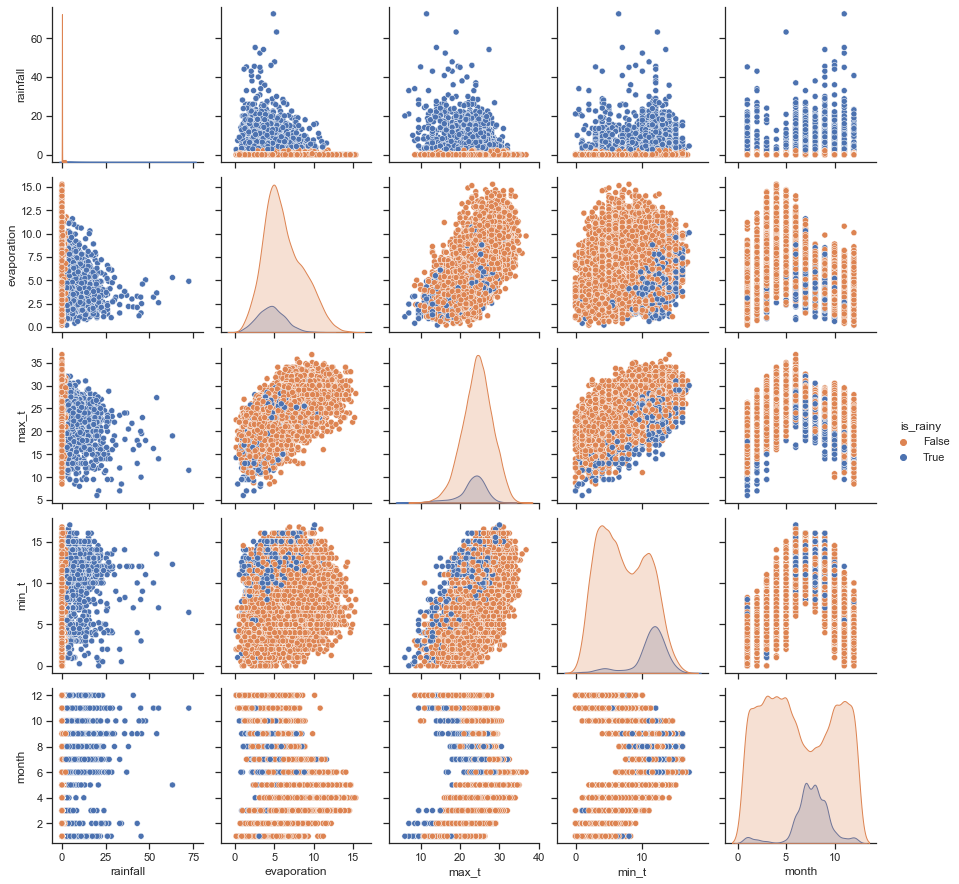

In [38]:
sns.set(style="ticks", color_codes=True)

colors = ["#dd8452", "#4c72b0"]
sns.pairplot(df_region, hue = 'is_rainy', palette = sns.color_palette(colors))
plt.show()

They are not very obvious, but there are several correlations to the target variable `rainfall`.

* The less evaporation, the more rain.

This seems counterintuitive, but remember that evaporation is measured by measuring the difference in height at the beginning and end of the day in a container bucket. On rainy days, clouds often cast shade that reduces the amount of solar irradiation.

* It rains more when the minimum temperature is higher.

* It is not so clear how the maximum temperature affects, it is only clear that it should not be extreme.

* Naturally there are months that are rainier than others, the so-called rainy season.

* In the graphs with only maximum and minimum temperature, it is shown that an lineal distribution is formed, and that the rainy days occur in a limited region of these. It seems that both the minimum temperature must be high and the maximum temperature low, that is, moderate days.



In [43]:
df_monthly = rm_region.PeriodicMedians(
    'M',
    date_interval=(date(1970,1,1), None)
).df

df_monthly

,rainfall,evaporation,max_t,min_t,rainy_days,month
date,,,,,,
1970-01-01,0.0,5.200,20.000,3.00,1,1
1970-02-01,0.0,5.600,20.625,4.00,3,2
1970-03-01,0.0,7.400,23.000,4.50,0,3
1970-04-01,0.0,9.325,27.500,7.00,0,4
1970-05-01,0.0,7.950,28.000,8.00,0,5
...,...,...,...,...,...,...
2018-08-01,1.0,4.600,26.000,10.00,14,8
2018-09-01,3.0,2.950,24.000,11.50,16,9
2018-10-01,0.0,1.900,23.000,7.75,5,10


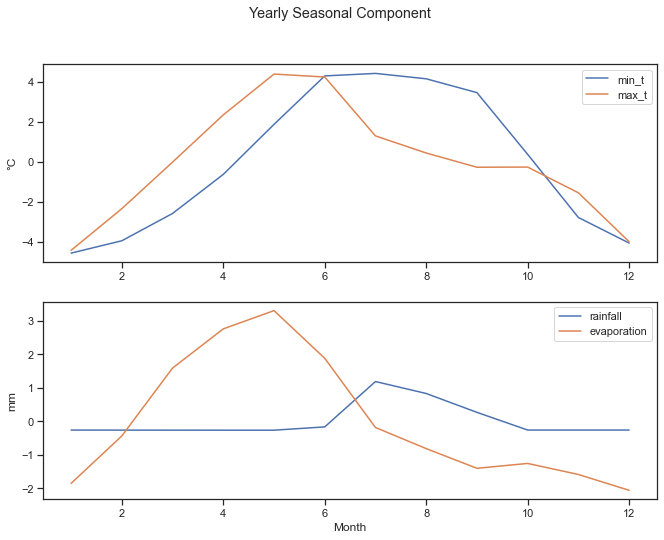

In [44]:
title = 'Yearly Seasonal Component'
column_pairs = [['min_t','max_t'], ['rainfall', 'evaporation']]
ylabels = ['°C', 'mm']
xlabels = ['', 'Month']
dataframe = df_monthly


def month(series):
    dataframe = series.to_frame()
    dataframe['month'] = dataframe.index.month
    
    
    return dataframe.groupby('month').mean()


def data_function(column):
    return seasonal_dataframe_operation(dataframe, column, 'seasonal',
                                        month, period=12*11)

plotter(data_function, column_pairs, title, ylabels, xlabels)

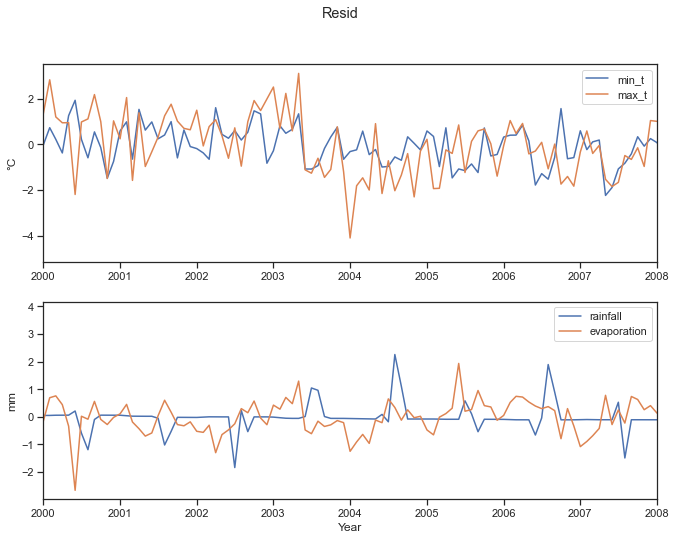

In [45]:

title = 'Resid'
column_pairs = [['min_t','max_t'], ['rainfall', 'evaporation']]
ylabels = ['°C', 'mm']
xlabels = ['', 'Year']
dataframe = df_monthly
xlimits = [(date(2000,1,1), date(2008,1,1)) for _ in range(2)]

def data_function(column):
    return seasonal_dataframe_operation(dataframe, column, 'resid',
                                        lambda x: x, period=12*11)

plotter(data_function, column_pairs, title, ylabels, xlabels, xlimits)

In [46]:
df_weekly = rm_region.PeriodicMedians(
    'W',
    date_interval=(date(1970,1,1), None)
).df

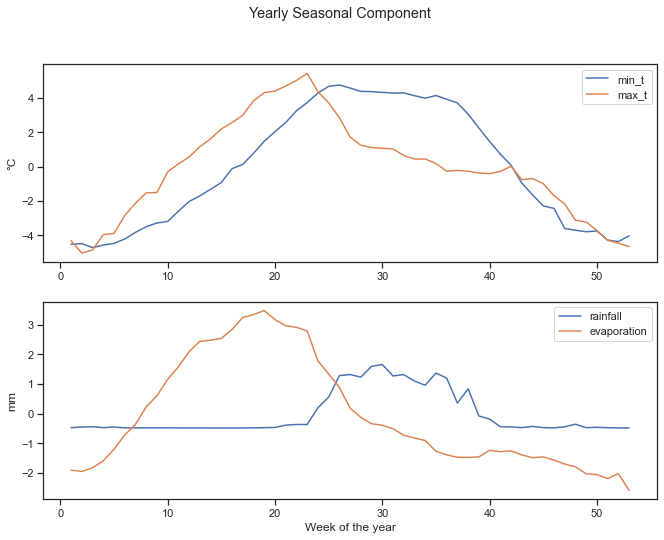

In [48]:
title = 'Yearly Seasonal Component'
column_pairs = [['min_t','max_t'], ['rainfall', 'evaporation']]
ylabels = ['°C', 'mm']
xlabels = ['', 'Week of the year']
dataframe = df_weekly


def week(series):
    dataframe = series.to_frame()
    dataframe['week_of_year'] = dataframe.index.isocalendar().week
    
    
    return dataframe.groupby('week_of_year').mean()


def data_function(column):
    return seasonal_dataframe_operation(dataframe, column, 'seasonal',
                                        week, period=round(365*11/7))

plotter(data_function, column_pairs, title, ylabels, xlabels)

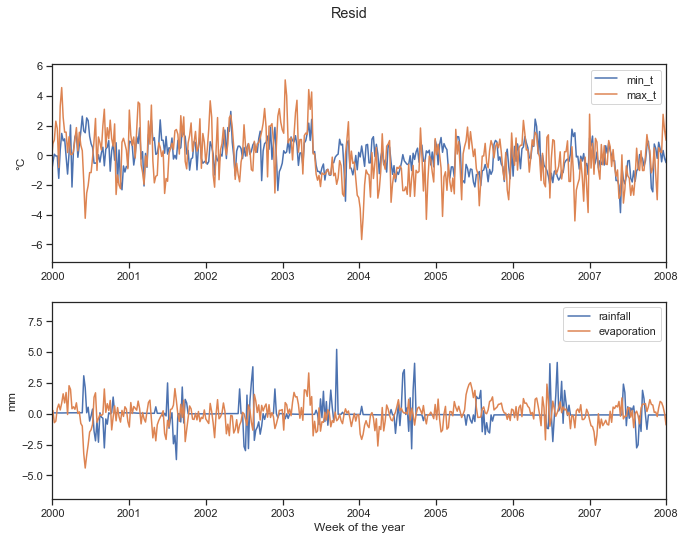

In [49]:

title = 'Resid'
column_pairs = [['min_t','max_t'], ['rainfall', 'evaporation']]
ylabels = ['°C', 'mm']
xlabels = ['', 'Week of the year']
dataframe = df_weekly
xlimits = [(date(2000,1,1), date(2008,1,1)) for _ in range(2)]

def data_function(column):
    return seasonal_dataframe_operation(dataframe, column, 'resid',
                                        lambda x: x, period=round(365*11/7))

plotter(data_function, column_pairs, title, ylabels, xlabels, xlimits)